# XGB Model Training and SHAP computation using the Synthetic-events Dataset

**Author: Tesfagabir Meharizghi<br>Last Updated: 01/29/2021**

In this jupyter notebook, we trained XGB models by SageMaker Hyperparameter Tuning (HPO) from the specified range of parameters.

Tasks done here are:
- Training XGB models with the specified range of parameters and datasets
- Computing different model performance measures such as AUCs, intersection similarity, RBOs, etc.
- Visualizing global and local SHAP scores and other performance scores
- And finally copying the well trained models to S3 if needed

Outputs:
- The following artifacts are saved:
    * Model artifacts
    * SHAP values and their corresponding scores for the specified number of val/test examples

Model Architecture Used:
- XGB

Dataset:
- Synthetic-events (Toy Dataset) - multiple

Requirements:
- Make sure that you have already generated multiple synthetic toy datasets (train/val/test splits) using [Create_toy_dataset_multiple.ipynb](../../data/toy_dataset/Create_toy_dataset_multiple.ipynb).

Discussions/observations:
- Since the models' parameters are automatically tuned from HPO, they are not as optimized as the ones manually specified.
- Some important tokens/events are missing from the top SHAP scores.
- However, the AUCs are still high as compared to a well-tuned model.

In [2]:
# pip install nb-black

In [3]:
#! pip install botocore==1.12.201

#! pip install shap
#! pip install xgboost

In [4]:
%load_ext lab_black

%load_ext autoreload

%autoreload 2

In [5]:
import sys

sys.path.append("../")

import os
import time
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.inspection import permutation_importance
import re
from scipy import stats

#!pip install -e git+https://github.com/changyaochen/rbo.git@master#egg=rbo
import rbo

from urllib.parse import urlparse
import tarfile
import pickle
import shutil
from collections import Counter, defaultdict, OrderedDict

import shap
import xgboost as xgb

import sagemaker
import boto3
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.image_uris import retrieve

import xgboost_utils as xgb_utils
import shap_jacc_utils as sj_utils

## XGB Model Training

### Constants

In [6]:
# Feature suffices that help predict the positive or negative class
HELPING_FEATURES_SUFFICES = ["_A", "_H", "_U"]  # Noises Removed

# Experiment number to run
EXP_NUMBER = 1
TRAIN_MODEL = False
TUNING_JOB_NAME = None

# Whether to preprocess data
PREPROCESS_DATA = False

# Whether to save SHAP scores
SAVE_SHAP_OUTPUT = True

# Whether to ouput SHAP explainer expected value
OUTPUT_SHAP_EXPLAINER = True

# Whether to shuffle val & test dataset for shap visualization purposes
SHUFFLE = False

# For seq_len=30
seq_len = 30

USE_FREQ = True  # Whether to use feature frequencies or one-hot for data preprocessing

nrows = 1e9

target_colname = "label"
uid_colname = "patient_id"
target_value = "1"

rev = False

model_name = "xgb"
dataset = "Synthetic-events"

# For model early stopping criteria
EARLY_STOPPING = "intersection_similarity"  # Values are any of these: ['intersection_similarity', 'loss']

# SHAP related constants
N_BACKGROUND = None  # Number of background examples
BACKGROUND_NEGATIVE_ONLY = False  # If negative examples are used as background
BACKGROUND_POSITIVE_ONLY = False  # If positive examples are used as background
TEST_POSITIVE_ONLY = False  # If only positive examples are selected
IS_TEST_RANDOM = (
    False  # If random test/val examples are selected for shap value computation
)
SORT_SHAP_VALUES = False  # Whether to sort per-patient shap values for visualization

SHAP_SCORE_ABSOLUTE = True  # Whether to consider the absolute value of a shap score #TODO: Check this before running.

train_data_path = (
    f"../../../data/toy_dataset/data/{seq_len}/experiments/{EXP_NUMBER:02}/train.csv"
)
valid_data_path = (
    f"../../../data/toy_dataset/data/{seq_len}/experiments/{EXP_NUMBER:02}/val.csv"
)
test_data_path = (
    f"../../../data/toy_dataset/data/{seq_len}/experiments/{EXP_NUMBER:02}/test.csv"
)

model_save_path = f"./output/Final_HPO_Tuned/{seq_len}/{EXP_NUMBER:02}/{model_name}/models/model_{'{}'}.pkl"
shap_save_path_pattern = f"./output/Final_HPO_Tuned/{seq_len}/{EXP_NUMBER:02}/{model_name}/shap/{'{}'}_shap_{'{}'}.pkl"  # SHAP values path for a given dataset split (train/val/test) (data format (features, scores, patient_ids))

# Dataset preprocessing
x_train_one_hot_path = (
    f"../output/{seq_len}/{EXP_NUMBER:02}/{model_name}/data/train_one_hot.csv"
)
x_valid_one_hot_path = (
    f"../output/{seq_len}/{EXP_NUMBER:02}/{model_name}/data/val_one_hot.csv"
)
x_test_one_hot_path = (
    f"../output/{seq_len}/{EXP_NUMBER:02}/{model_name}/data/test_one_hot.csv"
)

x_train_data_path = f"../output/{seq_len}/{EXP_NUMBER:02}/{model_name}/data/train.csv"
x_valid_data_path = f"../output/{seq_len}/{EXP_NUMBER:02}/{model_name}/data/val.csv"
x_test_data_path = f"../output/{seq_len}/{EXP_NUMBER:02}/{model_name}/data/test.csv"

s3_output_data_dir = (
    f"s3://merck-paper-bucket/{dataset}/Final_HPO_Tuned/{seq_len}/{EXP_NUMBER:02}/data"
)

# Model training
BUCKET = "merck-paper-bucket"
DATA_PREFIX = f"{dataset}/Final_HPO_Tuned/{seq_len}/{EXP_NUMBER:02}/data"
MODEL_PREFIX = (
    f"{dataset}/Final_HPO_Tuned/{seq_len}/{EXP_NUMBER:02}/{model_name}".format(seq_len)
)
label = "label"


hpo_output_results_path = f"output/Final_HPO_Tuned/{seq_len}/{EXP_NUMBER:02}/{model_name}/train_results/hpo_params.csv"
output_results_path = f"output/Final_HPO_Tuned/{seq_len}/{EXP_NUMBER:02}/{model_name}/train_results/results.csv"

local_model_dir = (
    f"output/Final_HPO_Tuned/{seq_len}/{EXP_NUMBER:02}/{model_name}/models/"
)
s3_output_path = f"s3://{BUCKET}/{MODEL_PREFIX}/output"

###Algorithm config
ALGORITHM = "xgboost"
REPO_VERSION = "1.2-1"

###Hyperparameter tuning config
TRAIN_INSTANCE_TYPE = "ml.m5.4xlarge"  #'ml.m4.16xlarge'
TRAIN_INSTANCE_COUNT = 1
MAX_PARALLEL_JOBS = 4
MAX_TRAIN_JOBS = 16

EVALUATION_METRIC = "auc"
OBJECTIVE = "binary:logistic"
OBJECTIVE_METRIC_NAME = "validation:auc"

HYPERPARAMETER_RANGES = {
    "eta": ContinuousParameter(0.1, 0.3),
    "alpha": ContinuousParameter(0, 1),
    "max_depth": IntegerParameter(1, 2),
    "gamma": ContinuousParameter(0, 2),
    "num_round": IntegerParameter(20, 50),
    "colsample_bylevel": ContinuousParameter(0.1, 0.2),
    "colsample_bynode": ContinuousParameter(0.1, 0.3),
    "colsample_bytree": ContinuousParameter(0.5, 0.7),
    "lambda": ContinuousParameter(0, 50),
    "max_delta_step": IntegerParameter(0, 3),
    "min_child_weight": ContinuousParameter(0, 5),
    "subsample": ContinuousParameter(0.5, 0.7),
}

In [7]:
if TRAIN_MODEL:
    # Model Output Directory
    model_save_dir = os.path.dirname(model_save_path)
    shap_save_dir = os.path.dirname(shap_save_path_pattern)

    if os.path.exists(model_save_dir):
        # Remove model save directory if exists
        shutil.rmtree(model_save_dir)
    if os.path.exists(shap_save_dir):
        # Remove model save directory if exists
        shutil.rmtree(shap_save_dir)
    os.makedirs(model_save_dir)
    os.makedirs(shap_save_dir)
    print(f"New directory created: {model_save_dir}")
    print(f"New directory created: {shap_save_dir}")

## 2. XGBoost Model Training

### Data Preprocessing

In [8]:
df = pd.read_csv(train_data_path)
print(df.shape)
df.head()

(18000, 33)


,index,29,28,27,26,25,24,23,22,21,...,7,6,5,4,3,2,1,0,label,patient_id
0,786,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,<pad>,<pad>,<pad>,<pad>,quad_injury_N,ingrown_nail_N,PH_A,hay_fever_N,1,CS1J522SGM
1,2944,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,quad_injury_N,apnea_H,ACL_tear_N,backache_N,furosemide_H,cut_finger_N,tachycardia_H,ankle_sprain_N,0,UWW1TK6765
2,157,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,cardiac_rehab_U,low_salt_diet_U,quad_injury_N,ACL_tear_N,cardiac_rehab_U,myopia_N,annual_physical_N,headache_N,0,VRW1KOT0QO
3,539,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,cut_finger_N,peanut_allergy_N,apnea_H,furosemide_H,backache_N,ingrown_nail_N,furosemide_H,hay_fever_N,0,TBGOONM7S7
4,384,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,ingrown_nail_N,ingrown_nail_N,peanut_allergy_N,backache_N,low_salt_diet_U,furosemide_H,cut_finger_N,backache_N,0,O8THNX6HZF


In [9]:
tokens = xgb_utils.get_valid_tokens(df, seq_len)

In [10]:
if PREPROCESS_DATA:
    xgb_utils.prepare_data(
        train_data_path,
        x_train_one_hot_path,
        x_train_data_path,
        seq_len,
        target_colname,
        tokens,
        s3_output_data_dir,
        use_freq=USE_FREQ,
    )
    xgb_utils.prepare_data(
        valid_data_path,
        x_valid_one_hot_path,
        x_valid_data_path,
        seq_len,
        target_colname,
        tokens,
        s3_output_data_dir,
        use_freq=USE_FREQ,
    )
    xgb_utils.prepare_data(
        test_data_path,
        x_test_one_hot_path,
        x_test_data_path,
        seq_len,
        target_colname,
        tokens,
        s3_output_data_dir,
        use_freq=USE_FREQ,
    )
else:
    local_dir = os.path.dirname(x_train_data_path)
    xgb_utils.copy_data_to_s3(local_dir, s3_output_data_dir)

Copying train data to S3...
Copying val data to S3...
Copying test data to S3...
Success!


### XGBoost Model Training

In [11]:
def load_xgb_classifier(model_path, model_params, feature_names=None):
    """Load XGBClassifier model from saved Booster model."""
    xgb_model = xgb.XGBClassifier(**model_params)
    if model_path.endswith(".gz"):
        xgb_model._Booster = xgb_utils.load_model(model_path, remove=False)
    else:
        xgb_model._Booster = sj_utils.load_pickle(model_path)

    if feature_names is not None:
        xgb_model._Booster.feature_names = feature_names

    return xgb_model


def get_model_paths(model_save_dir, sort=True):
    """Get list models paths in sorted order if needed."""
    fnames = os.listdir(model_save_dir)
    if sort:
        fnames.sort(key=lambda f: int(re.sub("\D", "", f)))
    model_paths = [os.path.join(model_save_dir, fname) for fname in fnames]
    return model_paths


def get_wtau(x, y):
    return stats.weightedtau(x, y, rank=None)[0]


# calculate ground truth scores
def is_value(x):
    if x.endswith("_N"):
        return False
    return True


def get_model_intersection_similarity_v2(features_scores, absolute=True):
    # gt similarity
    all_features, all_scores = features_scores[0], features_scores[1]
    sims = []
    for i, features in enumerate(all_features):
        scores = all_scores[i]
        gt_features = set([feature for feature in features if is_value(feature)])
        n_gt = len(gt_features)
        if n_gt > 0:
            dict_features_scores = sj_utils.create_dict_features_scores(
                features, scores, absolute
            )
            top_features_scores = sj_utils.top_k(dict_features_scores, len(gt_features))
            top_features = top_features_scores[0]
            pred_features = [feature for feature in top_features if is_value(feature)]
            sim = len(set(pred_features).intersection(gt_features)) / float(n_gt)
        else:
            sim = -1
        sims.append(sim)
    avg_sim = sum(sims) / len(sims)
    return avg_sim, sims


def compute_shap(xgb_model, df_train0, df_test0, explainer=None):
    # Load the copied model
    # xgb_model = sj_utils.load_pickle(model_path)

    df_train = df_train0.copy()
    df_test = df_test0.copy()

    feature_names = [
        col for col in df_train.columns.tolist() if col not in ["patient_id", "label"]
    ]
    X_train = df_train[feature_names]
    X_test = df_test[feature_names]

    if explainer is None:
        explainer = shap.TreeExplainer(xgb_model, X_train)
    shap_scores = explainer.shap_values(X_test).tolist()
    features = [feature_names[:]] * X_test.shape[0]
    patients = df_test.patient_id.tolist()

    return ((features, shap_scores, patients), explainer)


def save_results(patients, features, shap_scores, y_true, y_pred, output_path):
    """Save all model training results to file."""
    results = {}
    for i, patient_id in enumerate(patients):
        results[patient_id] = {}
        results[patient_id]["features_xgb"] = features[i]
        results[patient_id]["label"] = y_true[i]
        results[patient_id]["xgb_pred"] = y_pred[i]
        results[patient_id]["xgb_shap"] = shap_scores[i]

    output_dir = os.path.dirname(output_path)
    os.makedirs(output_dir, exist_ok=True)

    sj_utils.save_pickle(results, output_path, verbose=False)
    return results


def get_features_and_global_shap(results, exp_num=1):
    """Get a dataframe of features and global shap values."""
    features = None
    ##Get features and global shap
    all_shap = []
    for patient_id, result in results.items():
        if features is None:
            features = results[patient_id]["features_xgb"]
        all_shap.append(results[patient_id]["xgb_shap"])
    all_shap = np.absolute(np.array(all_shap)).mean(axis=0)
    df_shap = pd.DataFrame()
    df_shap["features"] = features
    df_shap["scores"] = all_shap
    df_shap["exp_num"] = exp_num
    return df_shap

In [12]:
df_train = pd.read_csv(x_train_one_hot_path)
df_val = pd.read_csv(x_valid_one_hot_path)
df_test = pd.read_csv(x_test_one_hot_path)

In [13]:
df_train.head()

,patient_id,ingrown_nail_N,headache_N,eye_exam_N,cardiac_rehab_U,hay_fever_N,cold_sore_N,CHF_A,backache_N,ARR_A,...,furosemide_H,myopia_N,PH_A,tachycardia_H,ACE_inhibitors_U,dental_exam_N,AMI_A,foot_pain_N,cut_finger_N,label
0,CS1J522SGM,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,UWW1TK6765,0,0,0,0,0,0,0,1,0,...,1,0,0,1,0,0,0,0,1,0
2,VRW1KOT0QO,0,1,0,2,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3,TBGOONM7S7,1,0,0,0,1,0,0,1,0,...,2,0,0,0,0,0,0,0,1,0
4,O8THNX6HZF,2,0,0,0,0,0,0,2,0,...,1,0,0,1,0,0,0,1,1,0


In [14]:
### SageMaker Initialization
region = boto3.Session().region_name
role = sagemaker.get_execution_role()
smclient = boto3.Session().client("sagemaker")

sess = sagemaker.Session()

container = retrieve(ALGORITHM, region, version=REPO_VERSION)

if TRAIN_MODEL:
    start = time.time()
    print("Training for seq_len={}, label={}...".format(seq_len, label))
    # Prepare the input train & validation data path
    s3_input_train = sagemaker.inputs.TrainingInput(
        s3_data="s3://{}/{}/train".format(BUCKET, DATA_PREFIX), content_type="csv"
    )
    s3_input_validation = sagemaker.inputs.TrainingInput(
        s3_data="s3://{}/{}/val".format(BUCKET, DATA_PREFIX), content_type="csv"
    )

    # Class Imbalance
    scale_pos_weight = 1.0  # negative/positive

    data_channels = {"train": s3_input_train, "validation": s3_input_validation}

    tuner = xgb_utils.train_hpo(
        hyperparameter_ranges=HYPERPARAMETER_RANGES,
        container=container,
        execution_role=role,
        instance_count=TRAIN_INSTANCE_COUNT,
        instance_type=TRAIN_INSTANCE_TYPE,
        output_path=s3_output_path,
        sagemaker_session=sess,
        eval_metric=EVALUATION_METRIC,
        objective=OBJECTIVE,
        objective_metric_name=OBJECTIVE_METRIC_NAME,
        max_train_jobs=MAX_TRAIN_JOBS,
        max_parallel_jobs=MAX_PARALLEL_JOBS,
        scale_pos_weight=scale_pos_weight,
        data_channels=data_channels,
    )

    # Get tuning job name
    smclient = boto3.Session().client("sagemaker")
    tuning_job_result = smclient.describe_hyper_parameter_tuning_job(
        HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
    )
    TUNING_JOB_NAME = tuning_job_result["HyperParameterTuningJobName"]

In [15]:
if TRAIN_MODEL:
    tuner = sagemaker.HyperparameterTuningJobAnalytics(TUNING_JOB_NAME)
    is_minimize = True

    full_df = tuner.dataframe()

    if len(full_df) > 0:
        df_hpo = full_df[full_df["FinalObjectiveValue"] > -float("inf")]
        if len(df_hpo) > 0:
            df_hpo = df_hpo.sort_values("FinalObjectiveValue", ascending=is_minimize)
            pd.set_option("display.max_colwidth", -1)  # Don't truncate TrainingJobName
        else:
            print("No training jobs have reported valid results yet.")

        # Add other info
        df_hpo["model"] = model_name
        df_hpo["dataset"] = dataset
        df_hpo["seq_len"] = seq_len
    else:
        print("No Training Job Found!")

    print(df_hpo.shape)
    df_hpo.head()

In [16]:
def get_and_copy_training_job(row, s3_output_dir, local_output_dir):
    """Get a training job from s3 and copy to local dir."""
    job_name = row["TrainingJobName"]
    s3_model_path = os.path.join(s3_output_dir, job_name, "output/model.tar.gz")

    if not os.path.exists(local_output_dir):
        os.makedirs(local_output_dir)

    output_fname = f"{job_name}.tar.gz"
    local_model_path = os.path.join(local_output_dir, output_fname)

    command = f"aws s3 cp --quiet {s3_model_path} {local_model_path}"
    os.system(command)
    return s3_model_path, local_model_path


def save_hpo_results(df, output_path):
    """Save HPO training jobs metadata."""
    output_dir = os.path.dirname(output_path)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    df["epoch"] = range(1, len(df) + 1)
    df.to_csv(output_path, index=False)

In [17]:
if TRAIN_MODEL:
    print("Copying model artifacts from s3 to local...")
    model_paths = df_hpo.apply(
        get_and_copy_training_job, args=(s3_output_path, local_model_dir), axis=1
    )
    s3_paths = [path[0] for path in model_paths]
    local_paths = [path[1] for path in model_paths]
    df_hpo["s3_path"] = s3_paths
    df_hpo["local_path"] = local_paths

    # print(f"Saving hpo train results to {output_results_path}...")
    save_hpo_results(df_hpo, hpo_output_results_path)
    print("SUCCESS!")
else:
    df_hpo = pd.read_csv(hpo_output_results_path)

In [18]:
df_hpo.head()

,alpha,colsample_bylevel,colsample_bynode,colsample_bytree,eta,gamma,lambda,max_delta_step,max_depth,min_child_weight,...,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,model,dataset,seq_len,s3_path,local_path,epoch
0,0.939181,0.105139,0.295303,0.593751,0.228340,0.160237,8.540369,2.0,1.0,1.523828,...,0.69154,2021-02-01 19:18:15+00:00,2021-02-01 19:19:57+00:00,102.0,xgb,Synthetic-events,30,s3://merck-paper-bucket/Synthetic-events/Final...,output/Final_HPO_Tuned/30/01/xgb/models/sagema...,1
1,0.144676,0.178682,0.132507,0.582707,0.193445,0.883029,25.843374,2.0,1.0,3.189133,...,0.79790,2021-02-01 19:14:43+00:00,2021-02-01 19:15:53+00:00,70.0,xgb,Synthetic-events,30,s3://merck-paper-bucket/Synthetic-events/Final...,output/Final_HPO_Tuned/30/01/xgb/models/sagema...,2
2,0.377108,0.160641,0.299966,0.609437,0.116320,1.609294,44.584680,0.0,1.0,3.650598,...,0.80407,2021-02-01 19:28:03+00:00,2021-02-01 19:29:02+00:00,59.0,xgb,Synthetic-events,30,s3://merck-paper-bucket/Synthetic-events/Final...,output/Final_HPO_Tuned/30/01/xgb/models/sagema...,3
3,0.984530,0.147164,0.134964,0.560609,0.106554,1.941326,13.994836,0.0,2.0,5.000000,...,0.81471,2021-02-01 19:21:52+00:00,2021-02-01 19:22:46+00:00,54.0,xgb,Synthetic-events,30,s3://merck-paper-bucket/Synthetic-events/Final...,output/Final_HPO_Tuned/30/01/xgb/models/sagema...,4
4,0.964530,0.147164,0.134964,0.560609,0.106554,1.901326,13.994836,0.0,2.0,4.927551,...,0.81772,2021-02-01 19:22:14+00:00,2021-02-01 19:23:10+00:00,56.0,xgb,Synthetic-events,30,s3://merck-paper-bucket/Synthetic-events/Final...,output/Final_HPO_Tuned/30/01/xgb/models/sagema...,5


In [19]:
# Get feature names
feature_names = [
    col for col in df_train.columns.tolist() if col not in ["patient_id", "label"]
]

In [20]:
# Get list of models paths
# model_paths = get_model_paths(model_save_dir, sort=False)
model_paths = df_hpo["local_path"].values.tolist()
# model_paths

In [21]:
def get_params(training_job_name, hpo_df):
    """Get the corresponding parameters for a given training job."""
    params = dict(hpo_df[hpo_df["TrainingJobName"] == job_name].iloc[0, :12])
    # Convert to int datatype to be compatible with the expectation
    params["gamma"] = int(params["gamma"])
    params["max_delta_step"] = int(params["max_delta_step"])
    params["max_depth"] = int(params["max_depth"])
    params["num_round"] = int(params["num_round"])
    return params

In [22]:
if TRAIN_MODEL:
    p_rbo = 0.9

    train_aucs = []
    val_aucs = []
    test_aucs = []

    train_losses = []
    val_losses = []
    test_losses = []

    gain_permute_rbo_scores = []
    gain_permute_tau_scores = []

    val_shap_sim_lst = []
    test_shap_sim_lst = []

    val_gain_shap_rbo_lst = []
    val_gain_shap_tau_lst = []

    epochs = []
    for model_path in model_paths:
        feature_names = [
            col
            for col in df_train.columns.tolist()
            if col not in ["patient_id", "label"]
        ]
        # Get epoch number from the model path
        model_fname = model_path
        model_fname = os.path.basename(model_path)

        job_name = os.path.basename(model_path)
        job_name = job_name.split(".")[0]

        epoch = df_hpo[df_hpo["TrainingJobName"] == job_name]["epoch"]
        epoch = int(epoch.values[0])
        epochs.append(epoch)

        model_params = get_params(job_name, df_hpo)
        xgb_model = load_xgb_classifier(model_path, model_params, feature_names)

        # feature_importances = xgb_model.feature_importances_
        feature_names = xgb_model.get_booster().feature_names

        # Compute AUCs
        train_y_true = df_train.label
        train_y_pred = xgb_model.predict_proba(df_train[feature_names])[:, 1]
        train_auc = roc_auc_score(train_y_true, train_y_pred)
        train_aucs.append(train_auc)

        val_y_true = df_val.label
        val_y_pred = xgb_model.predict_proba(df_val[feature_names])[:, 1]
        val_auc = roc_auc_score(val_y_true, val_y_pred)
        val_aucs.append(val_auc)

        test_y_true = df_test.label
        test_y_pred = xgb_model.predict_proba(df_test[feature_names])[:, 1]
        test_auc = roc_auc_score(test_y_true, test_y_pred)
        test_aucs.append(test_auc)

        # Losses
        train_loss = log_loss(train_y_true, train_y_pred)
        train_losses.append(train_loss)
        val_loss = log_loss(val_y_true, val_y_pred)
        val_losses.append(val_loss)
        test_loss = log_loss(test_y_true, test_y_pred)
        test_losses.append(test_loss)

        xgb_gain = pd.DataFrame(
            (xgb_model.get_booster().get_score(importance_type="gain")).items()
        )
        xgb_gain.columns = ["features", "xgb_gain"]

        feat_imp = pd.DataFrame(
            list(zip(feature_names, xgb_model.feature_importances_))
        )
        feat_imp.columns = ["features", "sk_gain"]

        df_gains = xgb_gain.merge(feat_imp, how="inner", on=["features"])

        df_gains["xgb_rank"] = df_gains["xgb_gain"].rank(ascending=False)
        df_gains["sk_rank"] = df_gains["sk_gain"].rank(ascending=False)
        df_gains.sort_values("xgb_gain", ascending=False)
        # print(df_gains)

        feat_imp = pd.DataFrame(
            list(zip(feature_names, xgb_model.feature_importances_))
        )
        feat_imp.columns = ["features", "scores"]
        feat_imp.set_index("features", inplace=True)
        feat_imp.sort_values("scores", ascending=False, inplace=True)
        # feat_imp.plot.bar(figsize=(10, 5))
        # plt.title("Model Feature Importance Scores")

        # Check permutation
        perm_imp = permutation_importance(
            xgb_model, df_val[feature_names], df_val.label
        )

        perm_df = pd.DataFrame()
        perm_df["features"] = feature_names
        perm_df["scores"] = perm_imp.importances_mean
        perm_df.sort_values("scores", ascending=False, inplace=True)
        perm_df.set_index("features", inplace=True)
        # perm_df.plot.bar(figsize=(10, 5))
        # plt.title("Permutation Importance Scores")

        vals = feat_imp.merge(perm_df, left_index=True, right_index=True)
        vals["gain_rank"] = vals.scores_x.rank(ascending=False)
        vals["permute_rank"] = vals.scores_y.rank(ascending=False)

        gain_rank = vals.sort_values("gain_rank").index
        permute_rank = vals.sort_values("permute_rank").index

        # Plot for different p values
        #     rbo_scores = []
        #     p_vals = []
        #     p_range = range(1, 10)
        #     for p in p_range:
        #         rbo_score = rbo.RankingSimilarity(gain_rank.values, permute_rank.values).rbo(
        #             p=1.0 / p
        #         )
        #         rbo_scores.append(rbo_score)
        #         p_vals.append(1.0 / p)

        #     # plt.figure(figsize=(10, 5))
        #     plt.plot(p_vals, rbo_scores, marker="x")
        #     plt.title("RBO Rankings for different p values.")
        #     plt.xlabel("p")
        #     plt.ylabel("RBO")

        rbo_score = rbo.RankingSimilarity(gain_rank.values, permute_rank.values).rbo(
            p=p_rbo
        )
        gain_permute_rbo_scores.append(rbo_score)
        tau_score = get_wtau(vals.scores_x, vals.scores_y)
        gain_permute_tau_scores.append(tau_score)

        val_shap_results, explainer = compute_shap(
            xgb_model, df_train, df_val, explainer=None
        )
        (val_features, val_scores, val_patients) = val_shap_results
        avg_sim, _ = get_model_intersection_similarity_v2(
            (val_features, val_scores), absolute=True
        )
        val_shap_sim_lst.append(avg_sim)

        # Compute the shap global feature importance
        shap_global = np.absolute(np.array(val_scores)).mean(axis=0)
        df_shap = pd.DataFrame()
        df_shap["features"] = feature_names
        df_shap["scores"] = shap_global.tolist()
        df_shap.set_index("features", inplace=True)
        # df_shap["shap_rank"] = df_shap.scores.rank(ascending=False)
        # df_shap.sort_values("scores", ascending=False, inplace=True)

        vals = feat_imp.merge(df_shap, left_index=True, right_index=True)
        vals["gain_rank"] = vals.scores_x.rank(ascending=False)
        vals["shap_rank"] = vals.scores_y.rank(ascending=False)

        gain_rank = vals.sort_values("gain_rank").index
        shap_rank = vals.sort_values("shap_rank").index

        rbo_score_shap = rbo.RankingSimilarity(gain_rank.values, shap_rank.values).rbo(
            p=p_rbo
        )
        val_gain_shap_rbo_lst.append(rbo_score_shap)

        tau_score_shap = get_wtau(vals.scores_x, vals.scores_y)
        val_gain_shap_tau_lst.append(tau_score_shap)

        test_shap_results, _ = compute_shap(xgb_model, df_train, df_test, explainer)
        (test_features, test_scores, test_patients) = test_shap_results
        avg_sim, _ = get_model_intersection_similarity_v2(
            (test_features, test_scores), absolute=True
        )
        test_shap_sim_lst.append(avg_sim)

        # Save training results to file.
        shap_path = shap_save_path_pattern.format("val", epoch)
        results = save_results(
            val_patients, val_features, val_scores, val_y_true, val_y_pred, shap_path
        )

        shap_path = shap_save_path_pattern.format("test", epoch)
        results = save_results(
            test_patients,
            test_features,
            test_scores,
            test_y_true,
            test_y_pred,
            shap_path,
        )
        del xgb_model
        print(
            f"Epoch: {epoch:02} | Train Loss={train_loss:.4} | Train AUC={train_auc:.4} | Val Loss={val_loss:.4} | Val AUC={val_auc:.4} | RBO(p={p_rbo})={rbo_score:.4} | TAU={tau_score:.4}"
        )

In [23]:
if TRAIN_MODEL:
    # Aggregate results
    columns = [
        "epoch",
        "train_AUC",
        "val_AUC",
        "test_AUC",
        "train_Loss",
        "val_Loss",
        "test_Loss",
        "gain_permute_rbo",
        "gain_permute_tau",
        "val_GT_shap_sim",
        "test_GT_shap_sim",
        "val_gain_shap_rbo",
        "val_gain_shap_tau",
    ]

    df_results = pd.DataFrame(
        np.array(
            [
                epochs,
                train_aucs,
                val_aucs,
                test_aucs,
                train_losses,
                val_losses,
                test_losses,
                gain_permute_rbo_scores,
                gain_permute_tau_scores,
                val_shap_sim_lst,
                test_shap_sim_lst,
                val_gain_shap_rbo_lst,
                val_gain_shap_tau_lst,
            ]
        ).T,
        columns=columns,
    )
    df_results["epoch"] = df_results["epoch"].astype(int)
    df_results.set_index("epoch", inplace=True)
    # save results summary
    output_dir = os.path.dirname(output_results_path)
    os.makedirs(output_dir, exist_ok=True)
    df_results.to_csv(output_results_path)
else:
    # save results summary
    df_results = pd.read_csv(output_results_path)
    df_results.set_index("epoch", inplace=True)

In [24]:
df_results.head()

,train_AUC,val_AUC,test_AUC,train_Loss,val_Loss,test_Loss,gain_permute_rbo,gain_permute_tau,val_GT_shap_sim,test_GT_shap_sim,val_gain_shap_rbo,val_gain_shap_tau
epoch,,,,,,,,,,,,
1,0.703913,0.691542,0.690097,0.653231,0.655273,0.655726,0.796609,0.788037,0.464956,0.464878,0.838366,0.904330
2,0.810037,0.797900,0.801103,0.616972,0.618945,0.618549,0.582854,0.777763,0.599578,0.599600,0.790931,0.906030
3,0.811704,0.804072,0.797397,0.649801,0.650500,0.651926,0.676192,0.628310,0.533333,0.533333,0.772988,0.915909
4,0.815710,0.814715,0.804371,0.633483,0.633481,0.635019,0.588074,0.451455,0.475456,0.475956,0.660243,0.772525
5,0.817206,0.817724,0.806600,0.633465,0.633407,0.634990,0.614429,0.660052,0.422956,0.422033,0.639822,0.774859


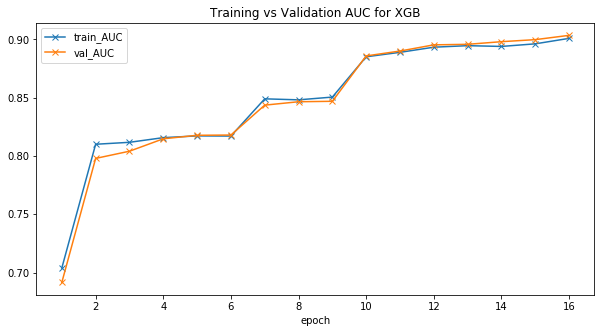

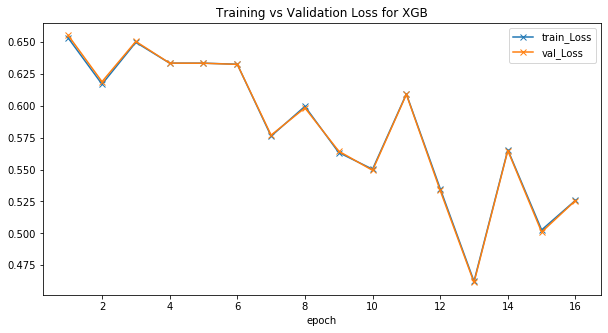

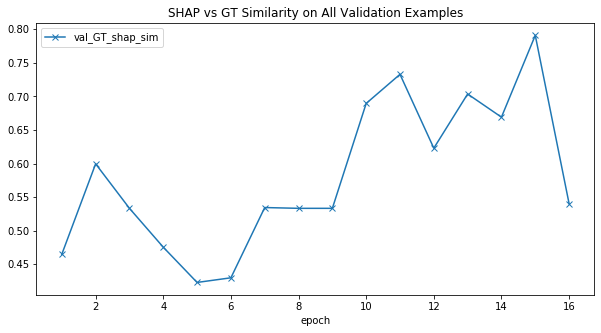

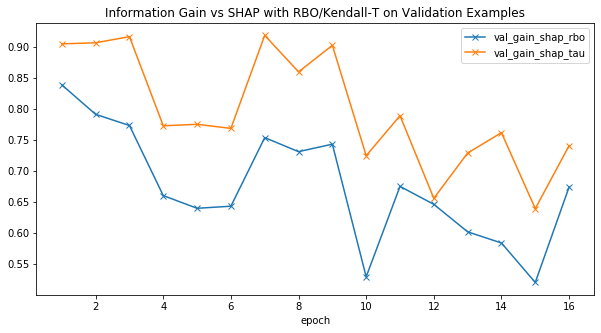

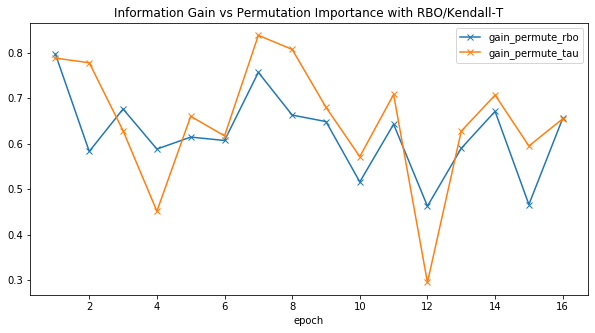

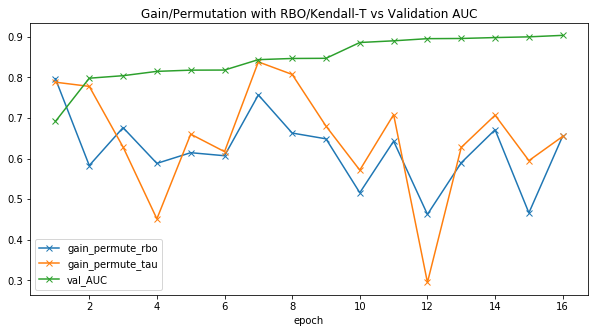

In [25]:
figsize = (10, 5)
df_results.reset_index().plot(
    figsize=figsize,
    x="epoch",
    y=["train_AUC", "val_AUC"],
    kind="line",
    marker="x",
)
plt.title("Training vs Validation AUC for XGB")

df_results.reset_index().plot(
    figsize=figsize,
    x="epoch",
    y=["train_Loss", "val_Loss"],
    kind="line",
    marker="x",
)
plt.title("Training vs Validation Loss for XGB")

df_results.reset_index().plot(
    figsize=figsize,
    x="epoch",
    y=["val_GT_shap_sim"],
    kind="line",
    marker="x",
)
plt.title("SHAP vs GT Similarity on All Validation Examples")

df_results.reset_index().plot(
    figsize=figsize,
    x="epoch",
    y=["val_gain_shap_rbo", "val_gain_shap_tau"],
    kind="line",
    marker="x",
)
plt.title("Information Gain vs SHAP with RBO/Kendall-T on Validation Examples")

df_results.reset_index().plot(
    figsize=figsize,
    x="epoch",
    y=["gain_permute_rbo", "gain_permute_tau"],
    kind="line",
    marker="x",
)
plt.title("Information Gain vs Permutation Importance with RBO/Kendall-T")

df_results.reset_index().plot(
    figsize=figsize,
    x="epoch",
    y=["gain_permute_rbo", "gain_permute_tau", "val_AUC"],
    kind="line",
    marker="x",
)
plt.title("Gain/Permutation with RBO/Kendall-T vs Validation AUC")

plt.show()

In [26]:
# Visualize SHAP

./output/Final_HPO_Tuned/30/01/xgb/shap/val_shap_1.pkl


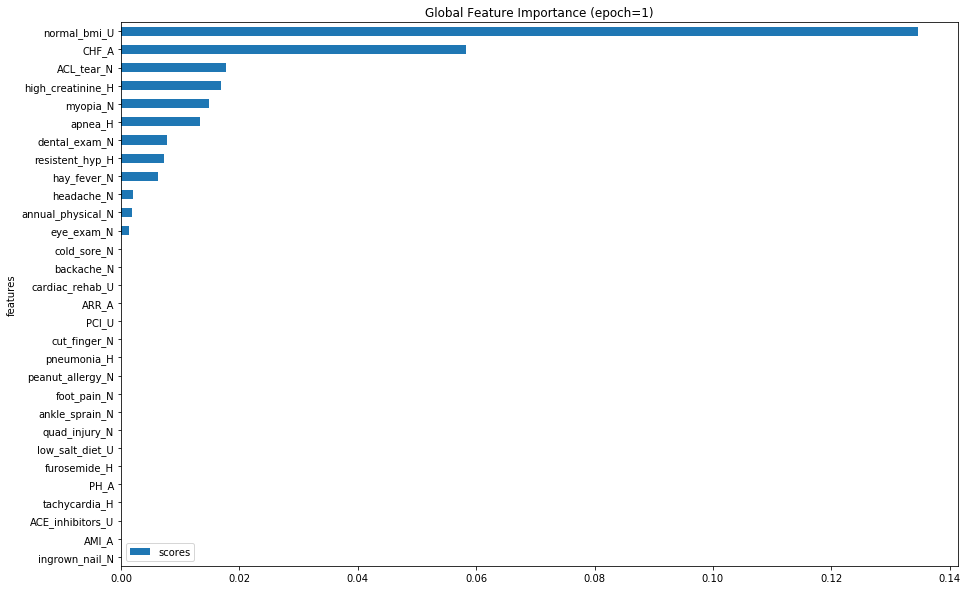

./output/Final_HPO_Tuned/30/01/xgb/shap/val_shap_2.pkl


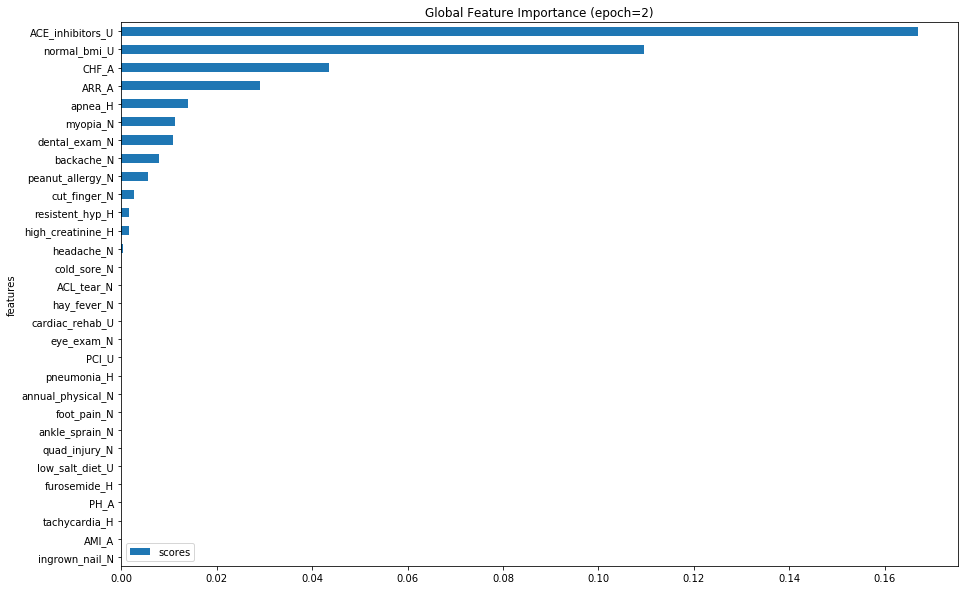

./output/Final_HPO_Tuned/30/01/xgb/shap/val_shap_3.pkl


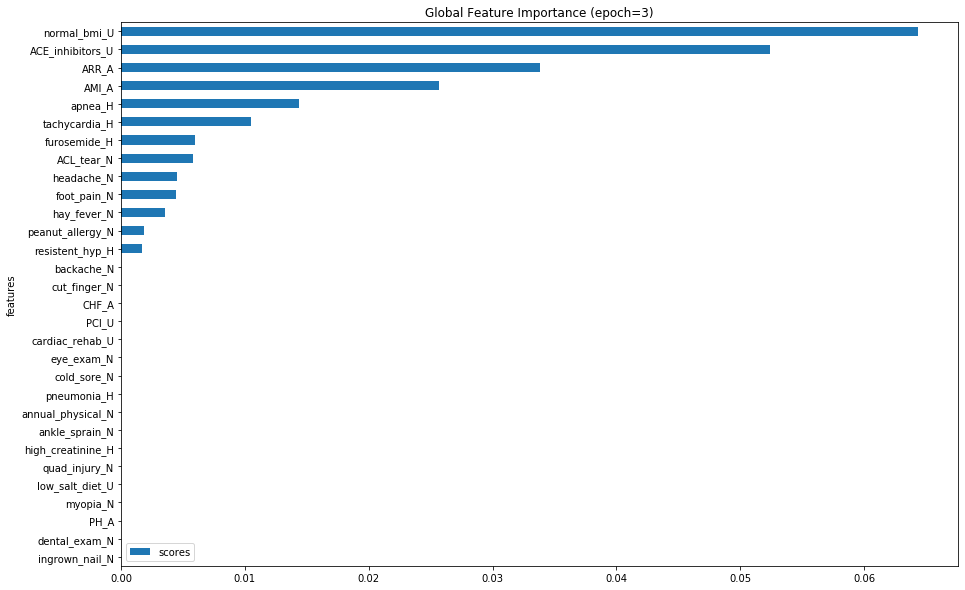

./output/Final_HPO_Tuned/30/01/xgb/shap/val_shap_4.pkl


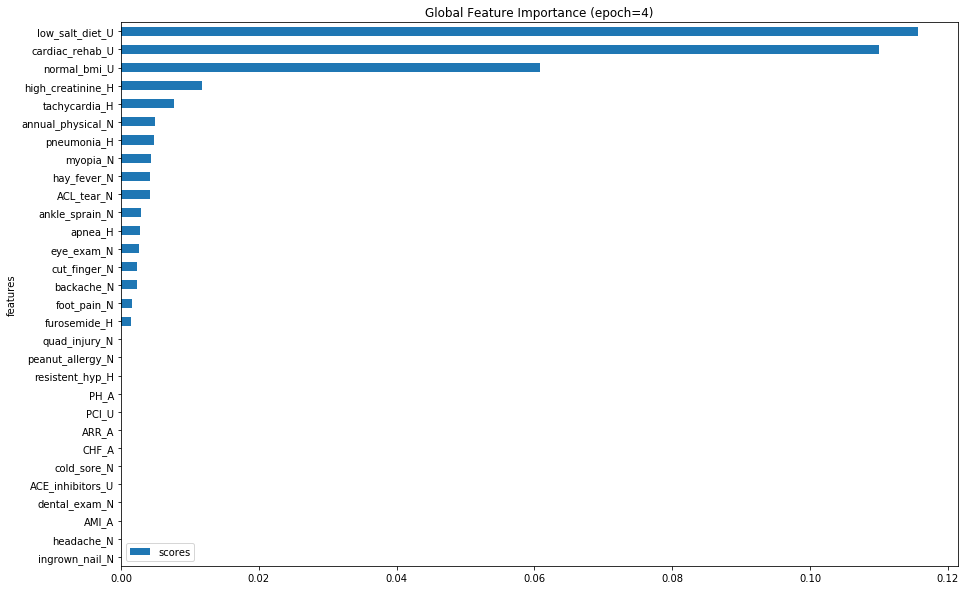

./output/Final_HPO_Tuned/30/01/xgb/shap/val_shap_5.pkl


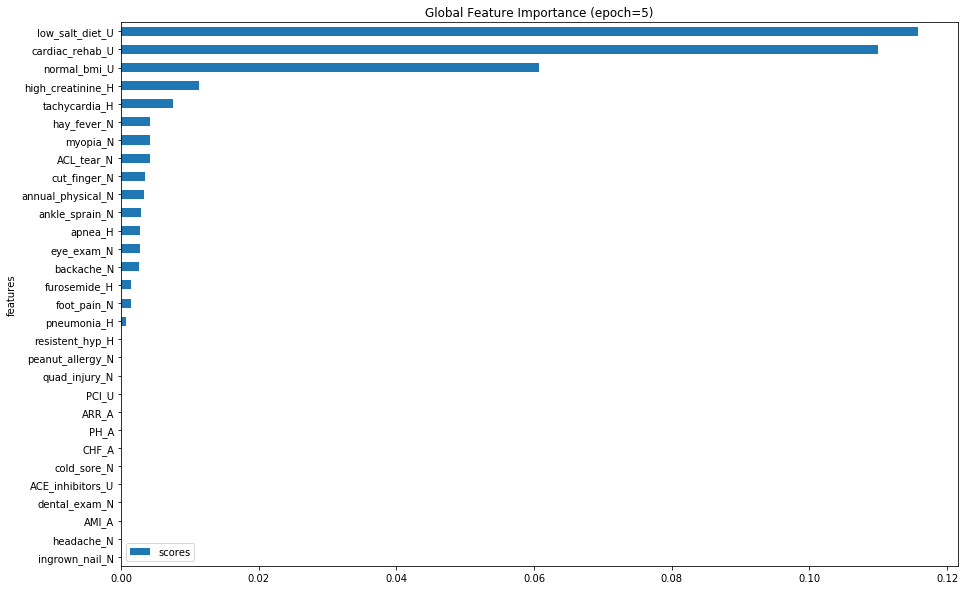

./output/Final_HPO_Tuned/30/01/xgb/shap/val_shap_6.pkl


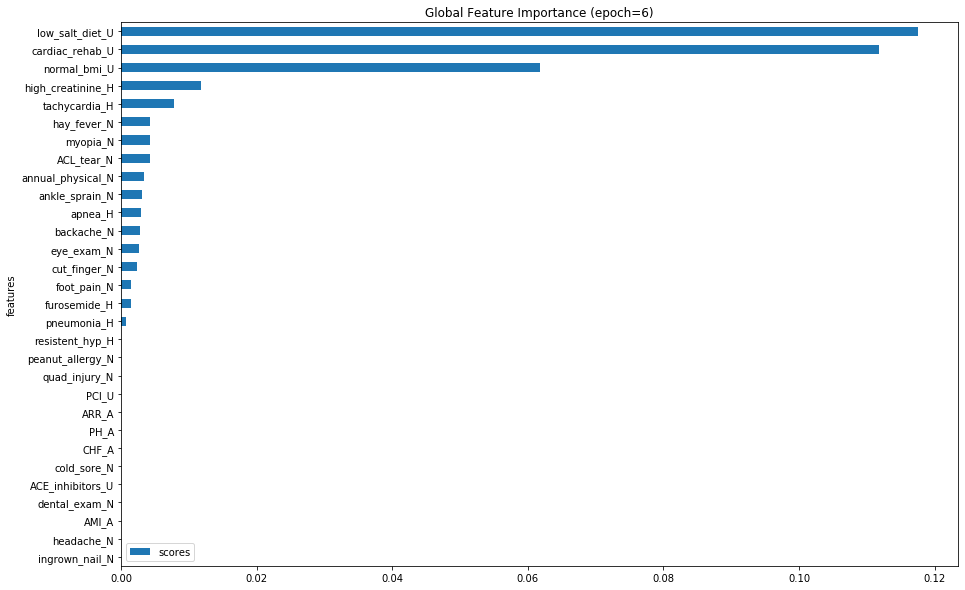

./output/Final_HPO_Tuned/30/01/xgb/shap/val_shap_7.pkl


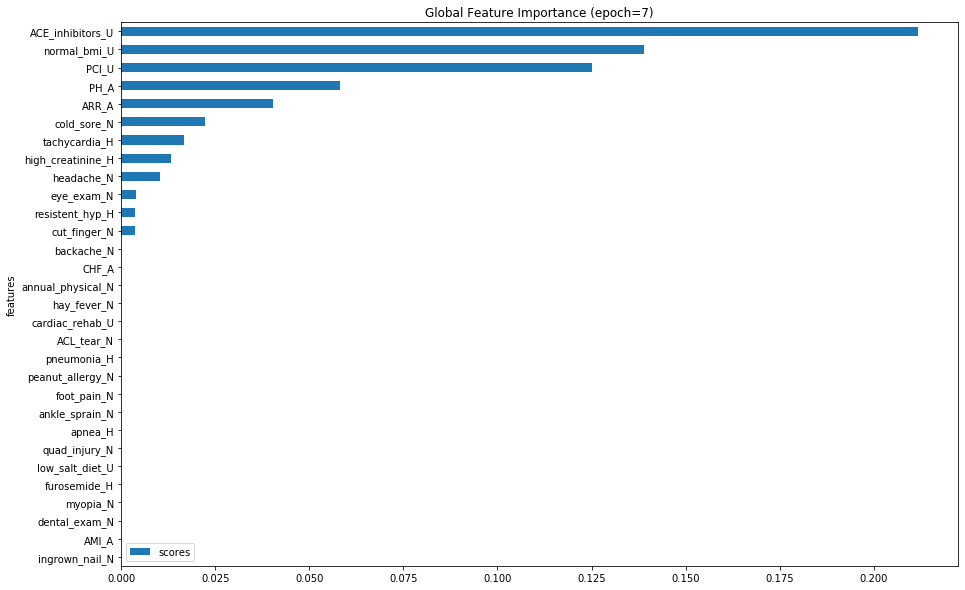

./output/Final_HPO_Tuned/30/01/xgb/shap/val_shap_8.pkl


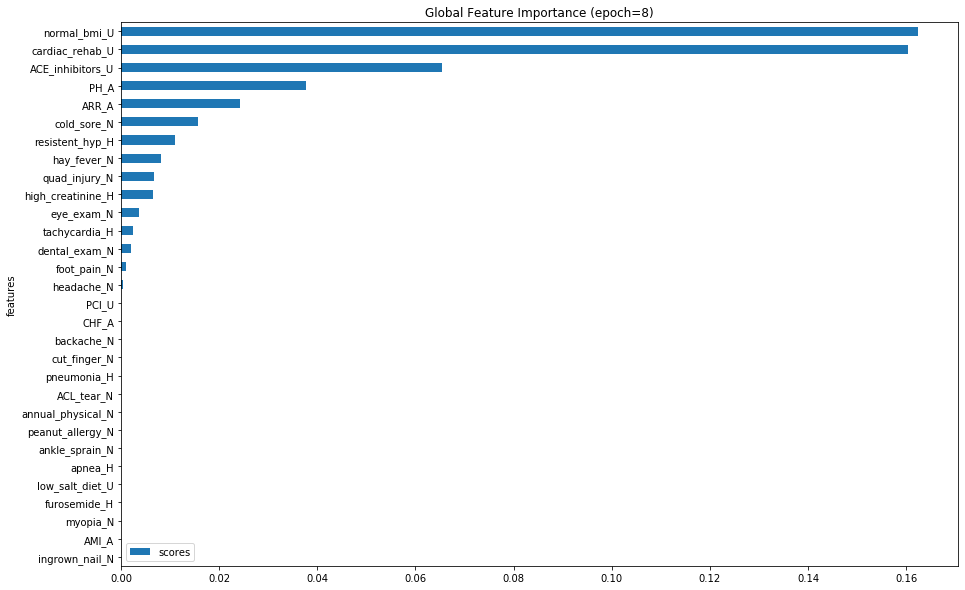

./output/Final_HPO_Tuned/30/01/xgb/shap/val_shap_9.pkl


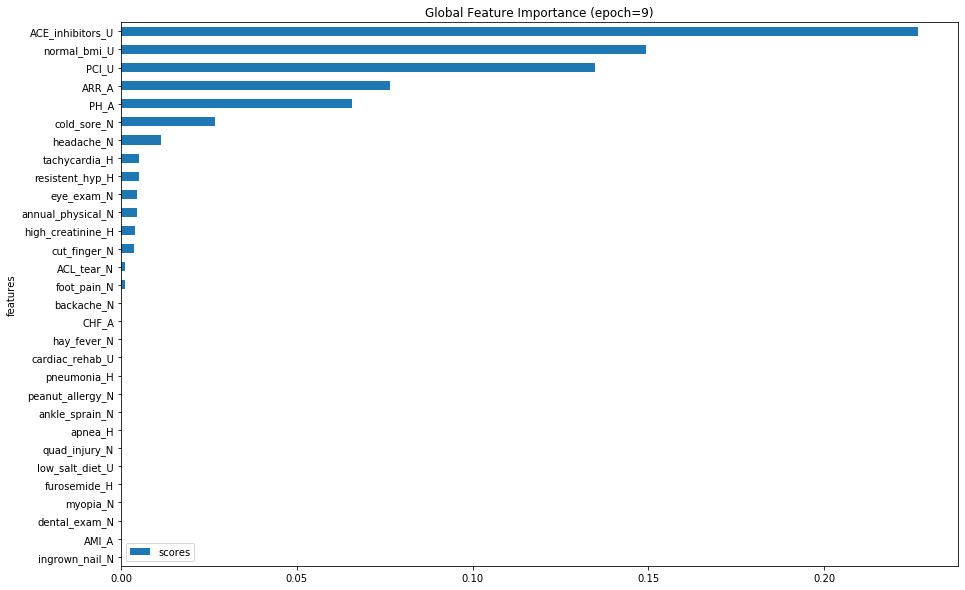

./output/Final_HPO_Tuned/30/01/xgb/shap/val_shap_10.pkl


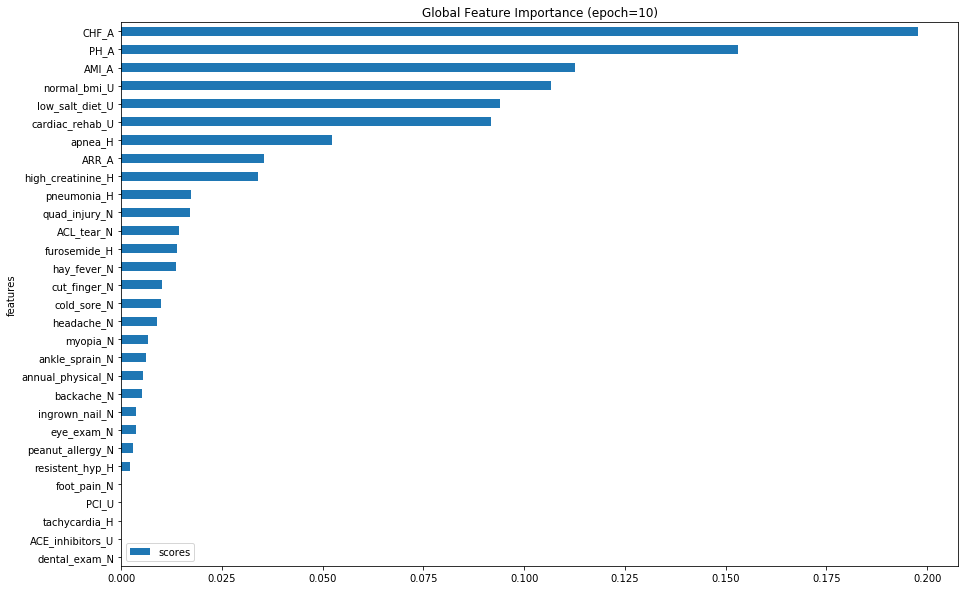

./output/Final_HPO_Tuned/30/01/xgb/shap/val_shap_11.pkl


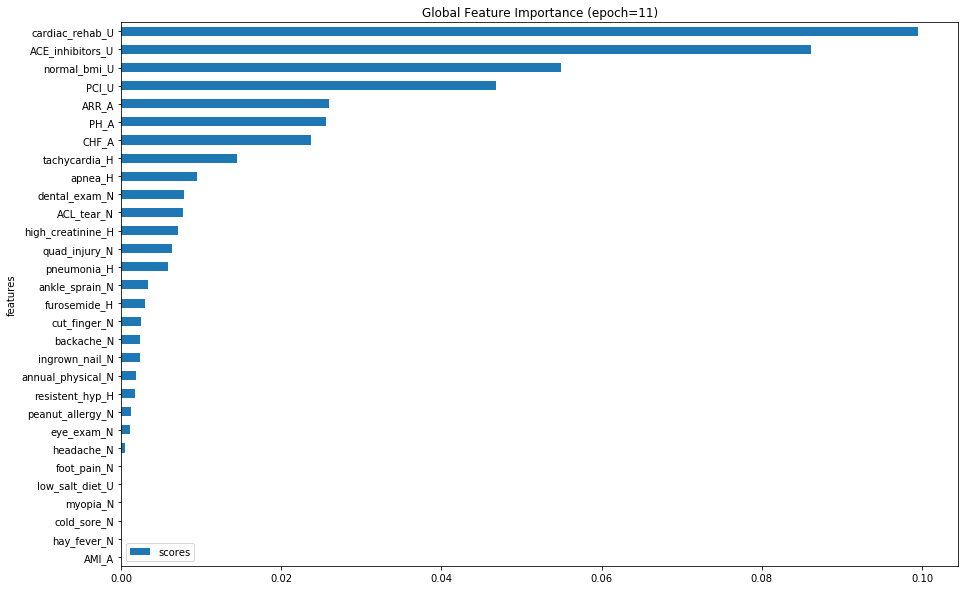

./output/Final_HPO_Tuned/30/01/xgb/shap/val_shap_12.pkl


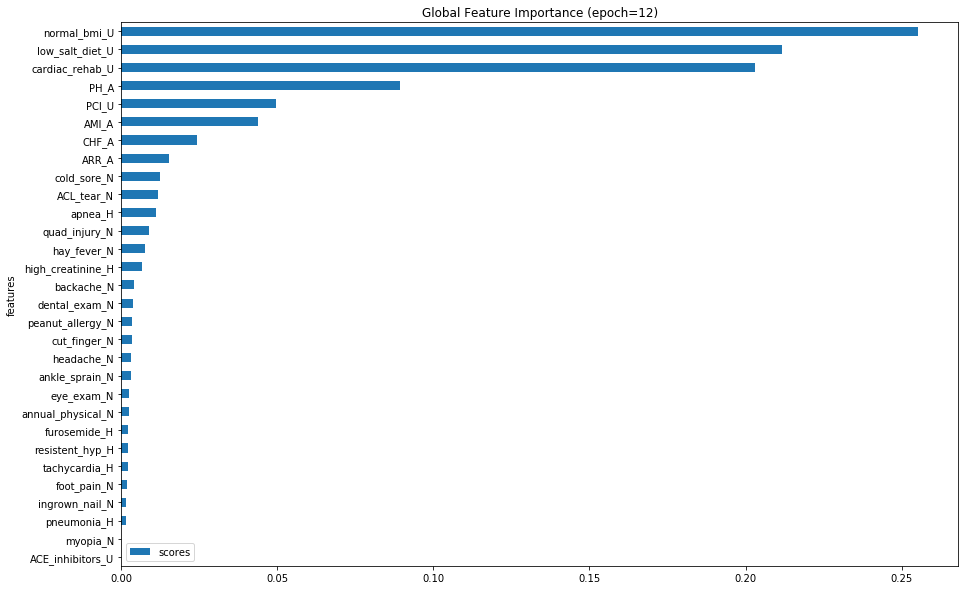

./output/Final_HPO_Tuned/30/01/xgb/shap/val_shap_13.pkl


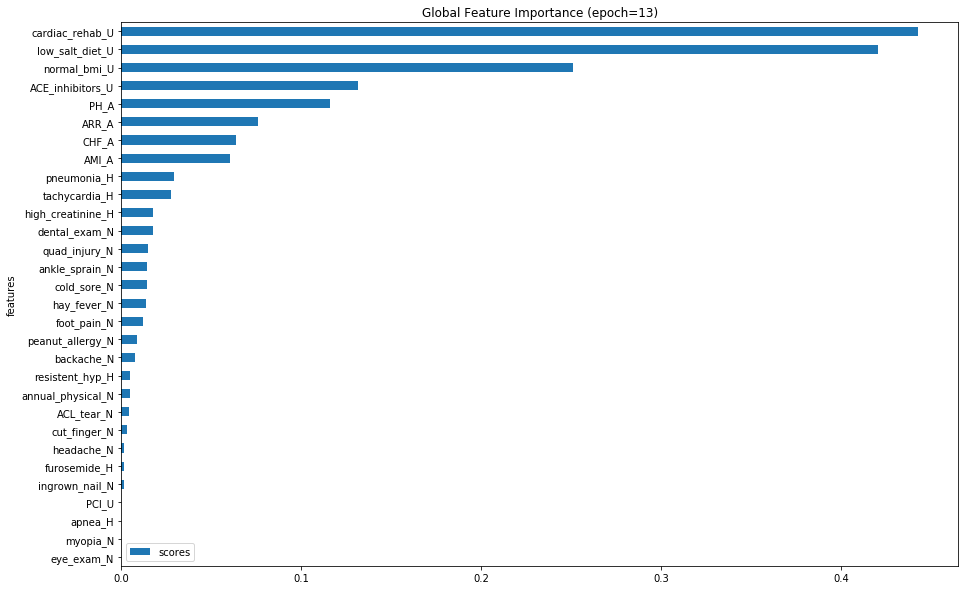

./output/Final_HPO_Tuned/30/01/xgb/shap/val_shap_14.pkl


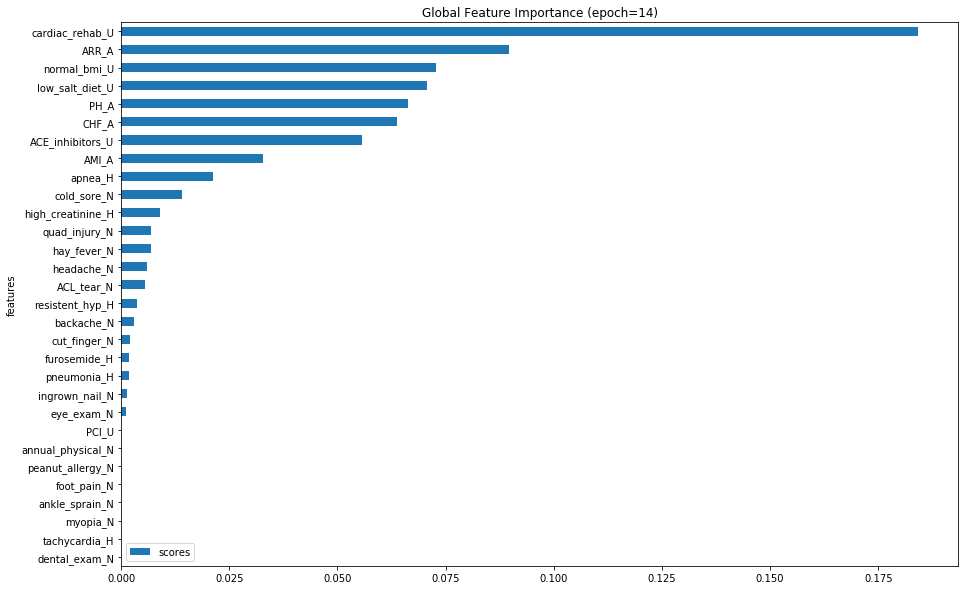

./output/Final_HPO_Tuned/30/01/xgb/shap/val_shap_15.pkl


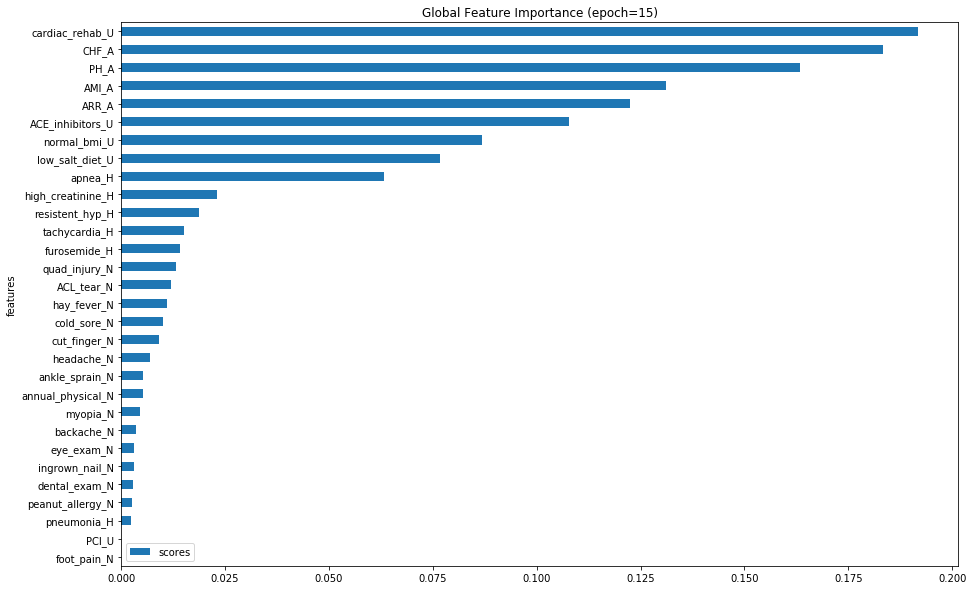

./output/Final_HPO_Tuned/30/01/xgb/shap/val_shap_16.pkl


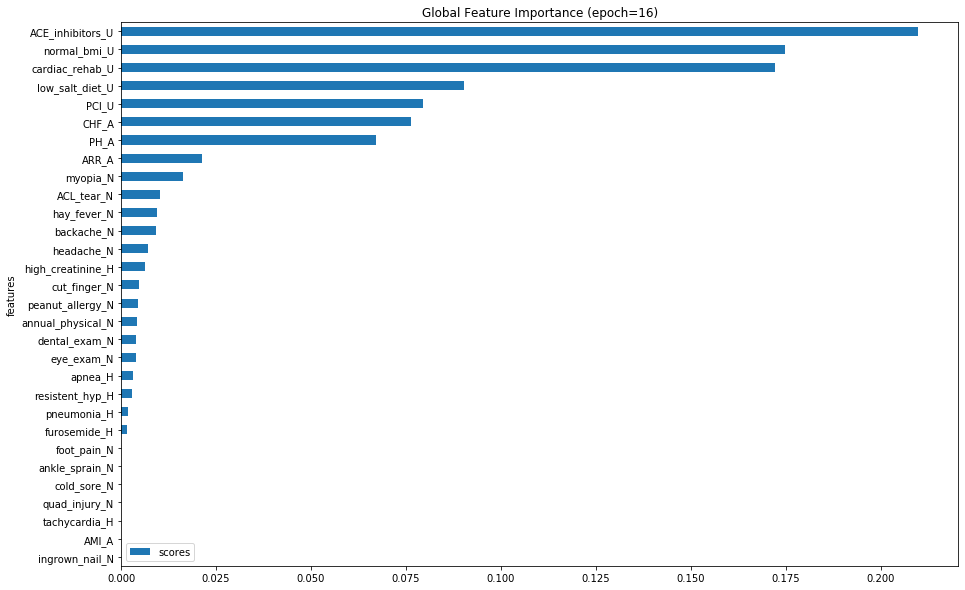

In [35]:
n_jobs = len(model_paths)
step = int(n_jobs / 2) - 1
# epochs = range(1, len(model_paths) + 1, 2)
step = 1
epochs = range(1, len(model_paths) + 1, step)
figsize = (15, 10)
for epoch in epochs:
    shap_path = shap_save_path_pattern.format("val", epoch)
    print(shap_path)
    val_results = sj_utils.load_pickle(shap_path)
    df_shap = get_features_and_global_shap(val_results)
    df_shap = df_shap.sort_values("scores", ascending=True)
    df_shap.plot(
        figsize=figsize,
        x="features",
        y="scores",
        kind="barh",
    )
    plt.title(f"Global Feature Importance (epoch={epoch})")
    plt.show()

In [28]:
data_dir = os.path.dirname(train_data_path)
patients_path = os.path.join(data_dir, "visualized_test_patients.txt")

with open(patients_path, "r") as fp:
    selected_patients = fp.readlines()
    selected_patients = [pat.strip() for pat in selected_patients]

selected_patients

['0XV60KZ3BF', 'OJI80KW377', 'R6EJJFP6XR', 'WFRQDJ5Q60']

In [29]:
n_jobs

16

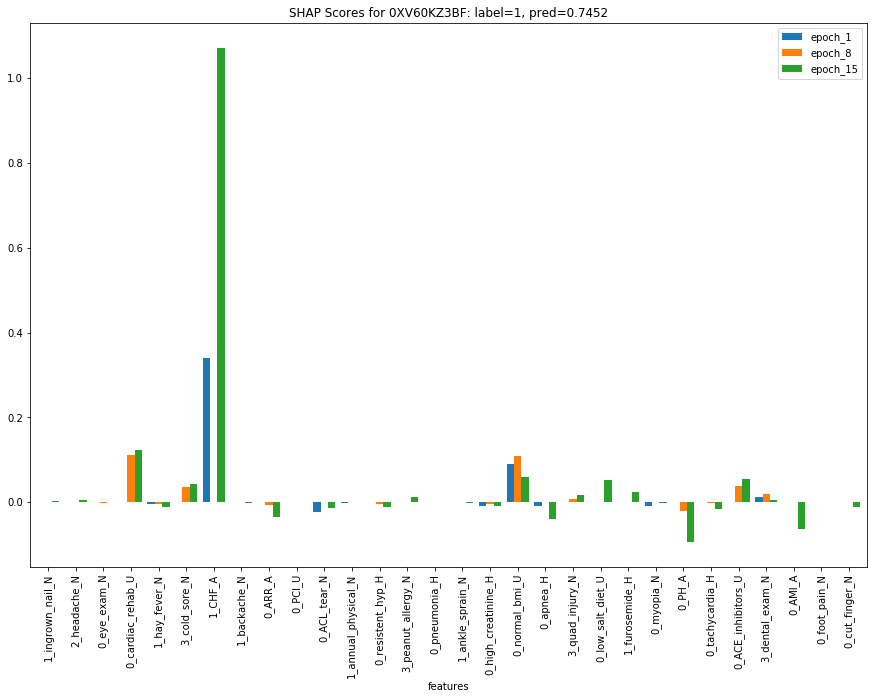

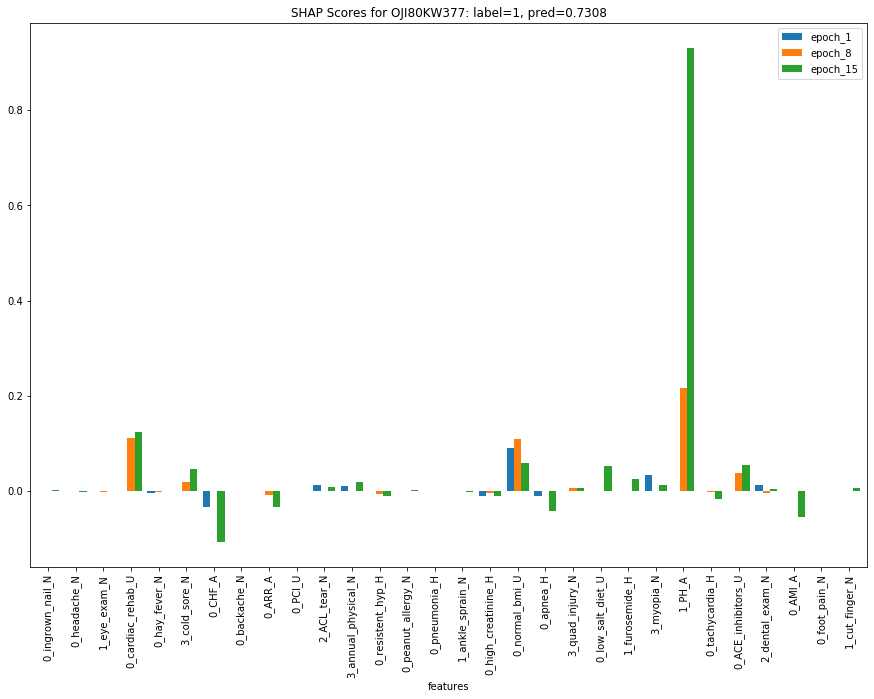

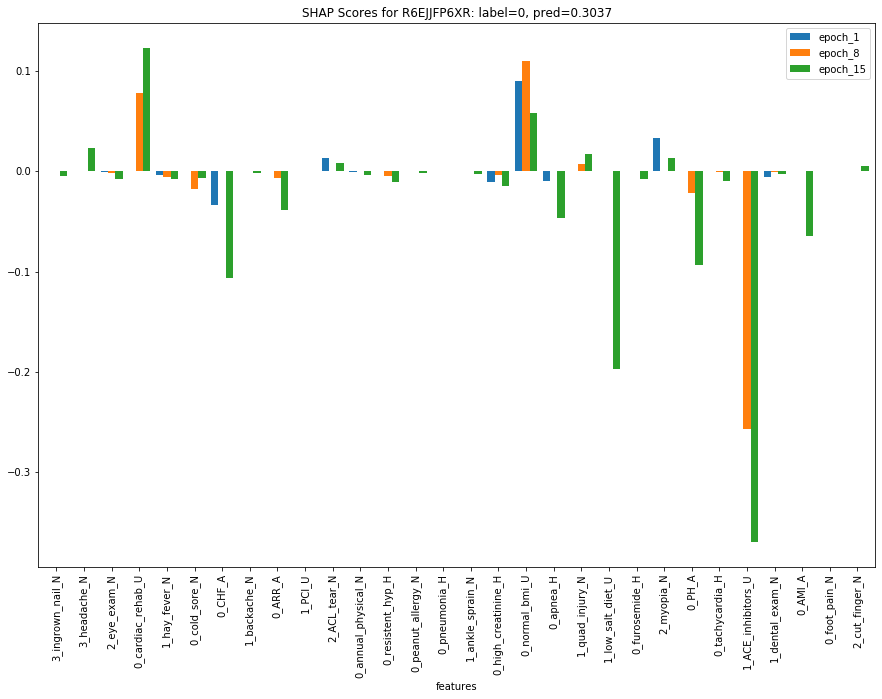

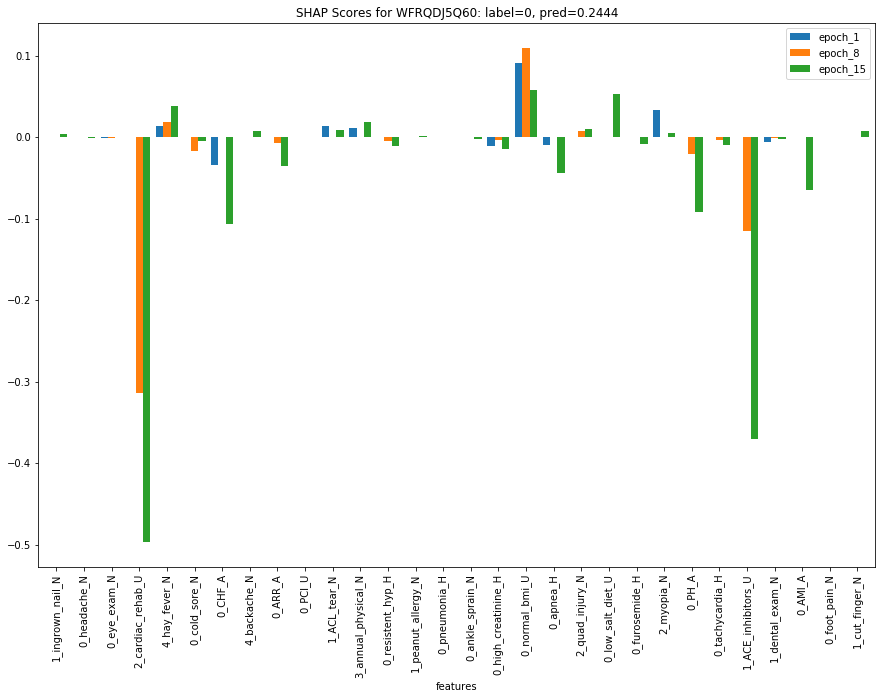

In [30]:
n_jobs = len(model_paths)
step = int(n_jobs / 2) - 1
# epochs = range(1, len(model_paths) + 1, 2)
epochs = range(1, len(model_paths) + 1, step)
for patient_id in selected_patients:
    df = pd.DataFrame()
    label = None
    pred_prob = None
    for epoch in epochs:
        shap_path = shap_save_path_pattern.format("test", epoch)
        test_results = sj_utils.load_pickle(shap_path)
        if not len(df):
            features = test_results[patient_id]["features_xgb"]
            df["features"] = features
            df["values"] = df_test[features][
                df_test["patient_id"] == patient_id
            ].values[0]
            df["features"] = df["values"].astype(str) + "_" + df["features"]
            label = test_results[patient_id]["label"]
        pred_prob = test_results[patient_id]["xgb_pred"]
        df[f"epoch_{epoch}"] = test_results[patient_id]["xgb_shap"]
    figsize = (15, 10)
    epoch_cols = [f"epoch_{epoch}" for epoch in epochs]
    df.plot(
        figsize=figsize,
        x="features",
        y=epoch_cols,
        kind="bar",
        width=0.8,
    )
    plt.title(f"SHAP Scores for {patient_id}: label={label}, pred={pred_prob:.4}")
    plt.show()

In [31]:
n_exps = 7
df = pd.DataFrame()
for n_exp in range(1, n_exps + 1):
    summary_path = f"output/Final_HPO_Tuned/{seq_len}/{n_exp:02}/{model_name}/train_results/results.csv"
    df_summary = pd.read_csv(summary_path)
    df_summary.set_index("epoch", inplace=True)
    best_epoch = df_summary["val_GT_shap_sim"].idxmax()

    best_results_path = f"./output/Final_HPO_Tuned/{seq_len}/{n_exp:02}/{model_name}/shap/test_shap_{best_epoch}.pkl"
    dict_results = sj_utils.load_pickle(best_results_path)
    df_shap = get_features_and_global_shap(dict_results, n_exp)

    df = pd.concat([df, df_shap], axis=0)

In [32]:
print(df.shape)
df.head()

(210, 3)


,features,scores,exp_num
0,ingrown_nail_N,0.003008,1
1,headache_N,0.006982,1
2,eye_exam_N,0.003056,1
3,cardiac_rehab_U,0.191636,1
4,hay_fever_N,0.010904,1


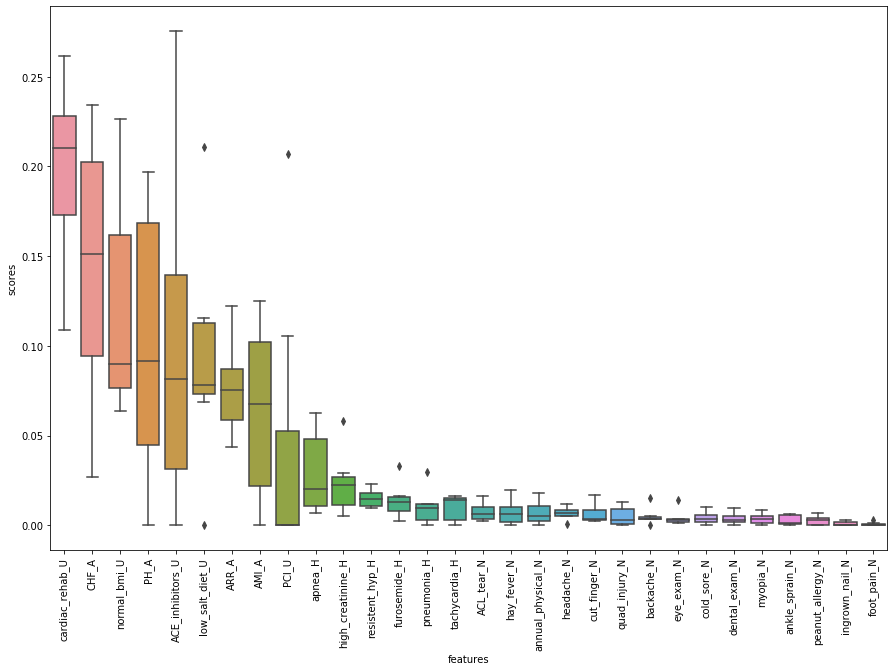

In [33]:
plt.figure(figsize=(15, 10))
df_mean = df.groupby("features")["scores"].mean()
df_mean.sort_values(ascending=False, inplace=True)
df_mean_cols = df_mean.index
ax = sns.boxplot(x="features", y="scores", data=df, order=df_mean_cols)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

In [34]:
# Copy best models results to S3
# n_exps = 10
# for n_exp in range(1, n_exps + 1):
#     print(f"Copying best model data to s3 for exp={n_exp}...")
#     summary_path = f"output/Final_HPO_Tuned/{seq_len}/{n_exp:02}/{model_name}/train_results/results.csv"
#     df_summary = pd.read_csv(summary_path)
#     df_summary.set_index("epoch", inplace=True)
#     best_epoch = df_summary["val_GT_shap_sim"].idxmax()

#     model_path = f"./output/Final_HPO_Tuned/30/10/xgb/models/model_{best_epoch}.pkl"
#     val_best_path = f"./output/Final_HPO_Tuned/{seq_len}/{n_exp:02}/{model_name}/shap/val_shap_{best_epoch}.pkl"
#     test_best_path = f"./output/Final_HPO_Tuned/{seq_len}/{n_exp:02}/{model_name}/shap/test_shap_{best_epoch}.pkl"

#     s3_dir = f"s3://merck-paper-bucket/Synthetic-events/final_event_30_xgb/{n_exp}/"

#     # copy files to s3
#     command_pattern = f"aws s3 cp {'{}'} {s3_dir}"

#     command = command_pattern.format(summary_path)
#     os.system(command)

#     command = command_pattern.format(model_path)
#     os.system(command)

#     command = command_pattern.format(val_best_path)
#     os.system(command)

#     command = command_pattern.format(test_best_path)
#     os.system(command)
# print("Models data successfully copied to S3!")